# 🔢 MNIST 손글씨 숫자 분류(Multi-class Classification)

🎯 손으로 쓴 숫자 이미지(0~9)를 보고 어떤 숫자인지 분류하는 문제

### 📌 1-1. MNIST 데이터셋 로드 및 샘플 수 확인

In [30]:
import matplotlib.pyplot as plt  # 추가 시각화용
import time
from sklearn.decomposition import PCA

# 데이터 로드
from torchvision import datasets
from torch.utils.data import DataLoader

# 데이터 저장 기본 경로 설정
data_dir = './data'

# 변환 없이 원본으로 다운로드 (전처리는 이후 진행)
train_raw = datasets.MNIST(root=data_dir, train=True, download=False)
test_raw  = datasets.MNIST(root=data_dir, train=False, download=False)

print(f"훈련 샘플 수: {len(train_raw)}개")
print(f"테스트 샘플 수: {len(test_raw)}개")

훈련 샘플 수: 60000개
테스트 샘플 수: 10000개


💡 설명
- MNIST 데이터셋은 총 60,000개의 훈련 이미지와 10,000개의 테스트 이미지로 구성
- 각 이미지는 28x28 픽셀의 흑백 손글씨 숫자이며, 0~9까지 총 10개의 클래스로 분류

---

### 📌 1-2. 데이터 시각화 (샘플 이미지 확인)

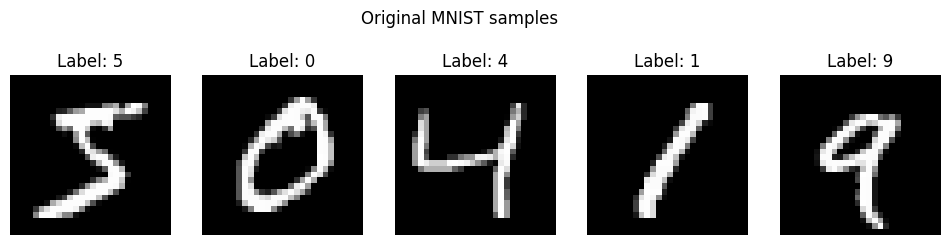

In [31]:
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    img, lbl = train_raw[i]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {lbl}")
    axes[i].axis('off')
plt.suptitle("Original MNIST samples")
plt.show()


---

### 📌 1-3.데이터 전처리 및 DataLoader 구성

In [34]:
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),                         
    transforms.Normalize((0.0,), (1,)),          
    transforms.Lambda(lambda x: x.view(-1))       
])

# transformation 진행
train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform)
test_dataset  = datasets.MNIST(root=data_dir, train=False, transform=transform)

# DataLoader 구성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

# numpy 변환 (정규화된 상태)
X_train = torch.stack([img for img, _ in train_dataset]).numpy()
y_train = torch.tensor([label for _, label in train_dataset])

X_test = torch.stack([img for img, _ in test_dataset]).numpy()
y_test = torch.tensor([label for _, label in test_dataset])

💡 설명
- 전처리 과정을 통해 모델 학습에 적합한 형태로 이미지 데이터가 변환
- 데이터가 정규화되어 딥러닝 모델 학습 시 수렴 속도 향상 및 성능 안정화에 기여

---

### 📌 1-4. 픽셀 값 분포 시각화 (정규화 확인)

💡 설명
- 전체 훈련 데이터의 픽셀 값을 시각화하여 정규화 상태를 확인
- ToTensor()와 Normalize((0.0,), (1.0,))를 적용한 결과, 픽셀 값이 0.0 또는 1.0에 집중되어 있는지를 확인

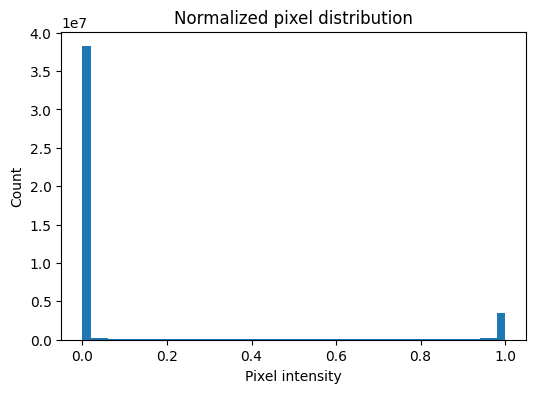

In [35]:
all_pixels = torch.cat([img for img, _ in train_dataset])
plt.figure(figsize=(6,4))
plt.hist(all_pixels.view(-1).numpy(), bins=50)
plt.title("Normalized pixel distribution")
plt.xlabel("Pixel intensity")
plt.ylabel("Count")
plt.show()

🔍 결과
- 대부분의 픽셀 값이 0.0 (배경) 혹은 1.0 (글자 부분)으로 분포되어 있음
- MNIST 데이터는 이진화된 흑백 이미지 형태로, 정규화 후 두 극단에 값이 몰림

---

### 📌 1-5. PCA를 활용한 MNIST 데이터 분포 시각화 (2D 차원 축소)

💡 설명
- PCA (Principal Component Analysis) 를 활용하여 고차원(784차원) 데이터를 2차원으로 축소
- MNIST 이미지 데이터의 패턴을 시각적으로 이해하기 위해 사용
- 각 점은 하나의 손글씨 숫자 이미지에 해당하며, 색상은 숫자 라벨(0~9) 을 나타냄
- 데이터의 클러스터링 가능성 및 분리 정도를 직관적으로 파악

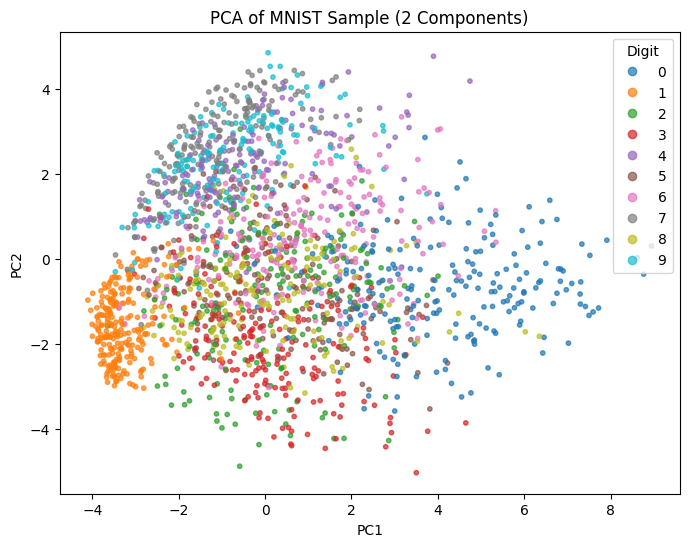

In [19]:
import numpy as np

sample_idx = np.random.choice(len(X_train), 2000, replace=False)
X_sample = X_train[sample_idx]
y_sample = y_train[sample_idx].numpy()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_sample, cmap='tab10', s=10, alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Digit")
plt.title("PCA of MNIST Sample (2 Components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

🔍 결과
- 일부 숫자(예: 0, 1, 3 등)는 다른 숫자와 뚜렷하게 구분되는 경향을 보임
- 그러나 일부 숫자(예: 4, 7, 9)는 분포가 겹쳐져 있어 구분이 어려움
- 이는 모델 학습 시 특정 숫자 간 혼동 가능성을 시사

---

### 📌 1-6. 정규화된 픽셀 값 분포 재확인 (ToTensor 이후)

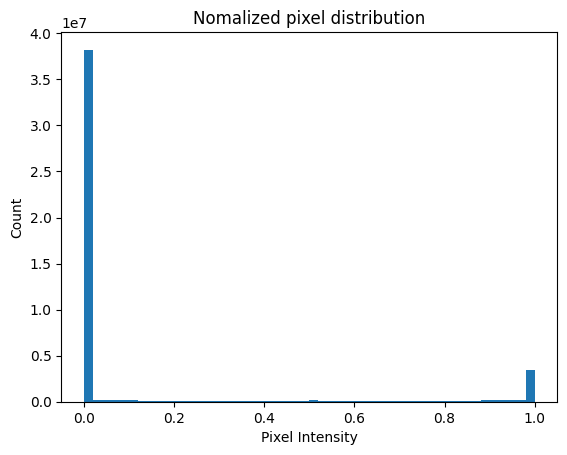

In [36]:
# 정규화 후 (ToTensor) 분포 확인
all_pixels = torch.cat([img for img, _ in train_dataset])
plt.hist(all_pixels.view(-1).numpy(), bins=50)
plt.title("Nomalized pixel distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.show()

🔍 결과
- 대부분의 픽셀 값이 여전히 0.0 (배경) 혹은 **1.0 (숫자)**에 집중되어 있음
- 중간 값(0.0과 1.0 사이)은 거의 없음 → 이진화 특성이 잘 유지됨.

---

### 📌 2-1. 분류 모델 학습을 위한 라이브러리 및 모델 불러오기

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### 📌 2-2. 모델 학습 및 성능 비교

In [38]:
# --------------------------------------------------
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        elapsed = time.time() - start
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = {'accuracy': acc, 'time': elapsed, 'y_pred': y_pred}
        print(f"{name}: Accuracy={acc:.3f}, Time={elapsed:.2f}s")
    return results

# 학습/검증 데이터 분할 (train_test_split)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 모델 딕셔너리 구성
classical_models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "SVM": SVC(kernel='rbf', gamma='scale'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
}

# 학습/평가 실행
results = train_and_evaluate_models(classical_models, X_train_sub, y_train_sub, X_test_sub, y_test_sub)


KNN: Accuracy=0.973, Time=0.02s
Decision Tree: Accuracy=0.858, Time=4.01s
SVM: Accuracy=0.978, Time=110.09s
Random Forest: Accuracy=0.969, Time=16.56s
XGBoost: Accuracy=0.977, Time=85.14s


🔍 결과
- SVM 모델이 가장 높은 정확도(97.8%)를 기록했지만, 학습 및 예측 시간이 매우 김 (110초)
- KNN은 정확도(97.3%)가 높고 속도도 매우 빠름, 소규모 데이터셋에 적합
- XGBoost는 균형 잡힌 성능을 보이며, 정확도 97.7% / 85초
- Decision Tree는 가장 낮은 정확도(85.8%)를 기록하여, 복잡한 데이터 분류에 적합하지 않음
- Random Forest는 빠른 속도(16초) 에 비해 높은 정확도(96.9%) 를 보임

➡️ 속도와 정확도의 균형을 고려할 때, KNN이나 Random Forest가 MNIST 분류 문제에 적합

➡️  정확도 최우선이라면 SVM 또는 XGBoost를 사용할 수 있으나, 시간적 자원이 충분할 때 유리

----

### 📌 2-3. 모델 성능 시각화 및 오분류 분석 (Confusion Matrix)

💡 설명
- 모델별 정확도와 학습 시간을 시각화하여 정량적 비교 수행
- 혼동 행렬(Confusion Matrix) 을 통해 각 모델의 오분류 패턴을 분석
- 숫자별로 어떤 클래스에서 오분류가 많이 발생했는지 확인 가능

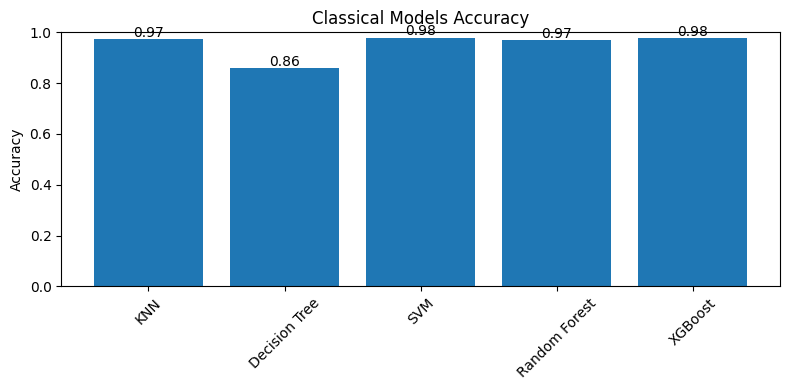

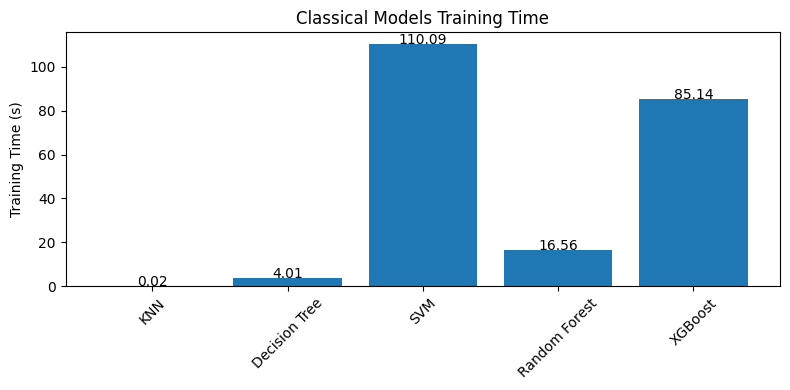

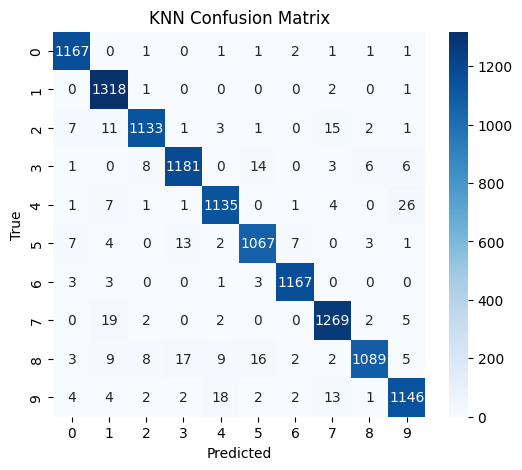

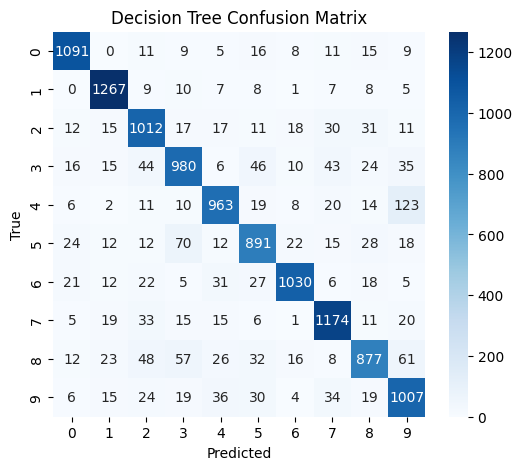

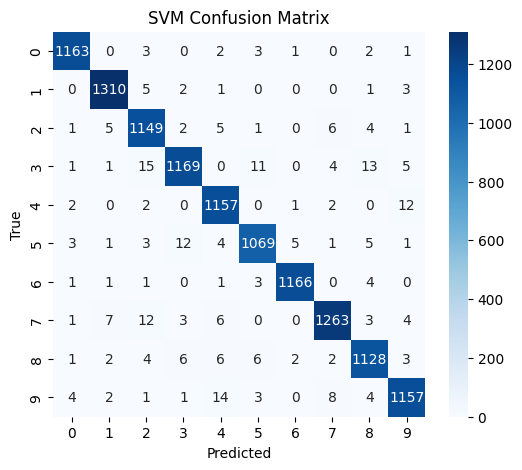

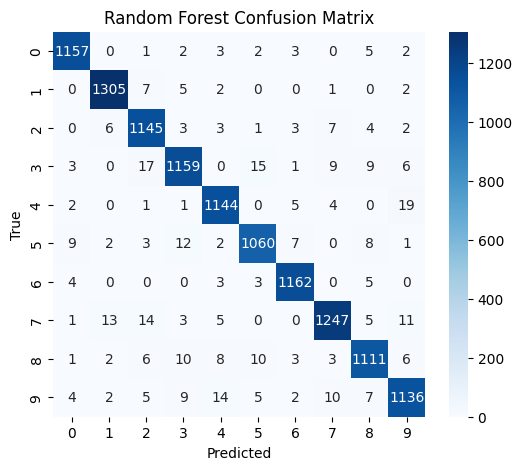

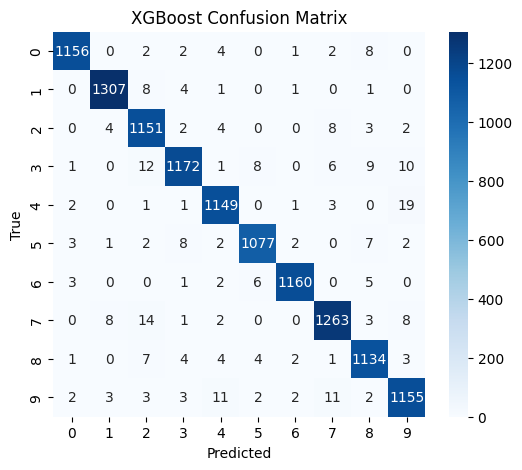

In [39]:
names = list(results.keys())
accs = [results[n]['accuracy'] for n in names]
times = [results[n]['time'] for n in names]

# 정확도 바 플롯
plt.figure(figsize=(8,4))
plt.bar(names, accs)
plt.ylabel("Accuracy")
plt.title("Classical Models Accuracy")
plt.ylim(0,1)
for i, v in enumerate(accs):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 학습 시간 바 플롯
plt.figure(figsize=(8,4))
plt.bar(names, times)
plt.ylabel("Training Time (s)")
plt.title("Classical Models Training Time")
for i, v in enumerate(times):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 혼동 행렬 일괄 시각화
for name in names:
    cm = confusion_matrix(y_test_sub, results[name]['y_pred'])
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


🔍 결과
1. 정확도 비교
- SVM과 XGBoost가 가장 높은 정확도(0.98)
- KNN과 Random Forest는 0.97로 뒤를 이음
- Decision Tree는 상대적으로 낮은 정확도(0.86)
➡️ SVM ≈ XGBoost > KNN ≈ Random Forest > Decision Tree
2. 학습 시간 비교
- KNN은 가장 빠른 학습 시간 (0.02초)
- SVM과 XGBoost는 높은 정확도지만, 학습 시간이 각각 110초, 85초로 김
- Random Forest는 성능 대비 효율적인 시간 (16초)
➡️ KNN < Decision Tree < Random Forest << XGBoost < SVM
3. 혼동 행렬 분석
- SVM, XGBoost는 전반적으로 오분류가 적음
- Decision Tree는 많은 숫자에서 오분류율이 높음, 특히 4와 9에서 혼동 발생
- 대부분의 모델이 4, 7, 9에서 유사 패턴으로 인한 혼동이 있는 것으로 보임

💡 결론
- 빠른 속도와 높은 정확도의 균형: Random Forest
- 최고 정확도 우선: SVM, XGBoost
- 단순한 모델 테스트용: KNN, Decision Tree

---

### 📌 3-1. CNN 모델 학습을 위한 데이터 준비 (DataLoader 재정의)

💡 설명
- CNN 모델은 이미지의 공간적 구조(2D 형태) 를 활용하여 특징을 추출하므로, Flatten 변환 없이 원본 형태 유지가 필요함

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# CNN용 DataLoader 재정의 (Flatten 제거)
transform_cnn = transforms.ToTensor()
train_dataset_cnn = datasets.MNIST(root='./data', train=True, transform=transform_cnn, download=True)
test_dataset_cnn = datasets.MNIST(root='./data', train=False, transform=transform_cnn, download=True)

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=64, shuffle=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)

### 📌 3-2. CNN 모델 설계 및 학습 결과

In [41]:
# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 28→14
        x = self.pool(torch.relu(self.conv2(x)))  # 14→7
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 모델 초기화 및 설정
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# CNN 학습 루프
for epoch in range(3):  # 에폭 수는 시간 단축을 위해 3으로 설정
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()

    for images, labels in train_loader_cnn:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1, Loss: 223.730, Accuracy: 92.80%
Epoch 2, Loss: 57.726, Accuracy: 98.10%
Epoch 3, Loss: 40.123, Accuracy: 98.68%


🔍 결과
- 3 Epoch 만에 98.68%의 높은 정확도 달성
- Epoch가 진행될수록 Loss 감소, 정확도 증가 → 모델 수렴 양호

➡️ CNN 모델은 MNIST 분류 문제에서 매우 효과적이며, 더 많은 Epoch와 Layer 확장 시 더 높은 성능 기대 가능

➡️ 머신러닝 모델 대비 공간적 특징을 효과적으로 반영하여 일반화 성능 우수

---

### 📌 3-3. 정확도 평가

In [42]:
# 테스트 정확도 측정
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader_cnn:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy of the CNN model: {100 * correct / total:.2f}%")

Test Accuracy of the CNN model: 98.94%


🔍 결과
- 98.94%의 높은 정확도를 달성
- 이는 머신러닝 기반 모델(KNN, SVM 등)보다 더 높은 성능이며, 짧은 학습 시간으로도 우수한 결과를 얻음

---

### 📌 4. 모델별 최종 테스트 정확도 비교

In [43]:
from sklearn.metrics import accuracy_score

results_cnn = {}

# KNN
results_cnn["KNN"] = accuracy_score(y_test_sub, classical_models["KNN"].predict(X_test_sub)) * 100

# Decision Tree
results_cnn["Decision Tree"] = accuracy_score(y_test_sub, classical_models["Decision Tree"].predict(X_test_sub)) * 100

# SVM
results_cnn["SVM"] = accuracy_score(y_test_sub, classical_models["SVM"].predict(X_test_sub)) * 100

# Random Forest
results_cnn["Random Forest"] = accuracy_score(y_test_sub, classical_models["Random Forest"].predict(X_test_sub)) * 100

# XGBoost
results_cnn["XGBoost"] = accuracy_score(y_test_sub, classical_models["XGBoost"].predict(X_test_sub)) * 100

# CNN
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader_cnn:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

results_cnn["CNN"] = 100 * correct / total

# 출력
print("모델별 Test Accuracy 결과 (단위: %)")
for model_name, acc in results_cnn.items():
    print(f"{model_name:15s}: {acc:.2f}%")

모델별 Test Accuracy 결과 (단위: %)
KNN            : 97.27%
Decision Tree  : 85.77%
SVM            : 97.76%
Random Forest  : 96.88%
XGBoost        : 97.70%
CNN            : 98.94%


🔍 결과
- CNN 모델이 98.94% 로 가장 높은 정확도를 기록
- SVM (97.76%), XGBoost (97.70%) 도 우수한 성능을 보임
- KNN (97.27%) 은 빠른 속도와 높은 정확도의 균형
- Decision Tree 는 상대적으로 낮은 정확도(85.77%)로 분류 문제에 부적합
- Random Forest 도 좋은 성능(96.88%)이지만 CNN보단 약간 낮음

💡 최종 결론

➡️ 정확도 최우선 시: CNN 선택 (테스트 데이터에서 가장 우수한 성능)

➡️ 학습 시간 고려 + 높은 정확도 시: KNN, Random Forest, XGBoost 가능

➡️ 단순한 모델/해석 용이성 시: Decision Tree 활용 가능하나 성능 한계 있음

➡️ 이미지 분류 문제에서는 딥러닝 기반 CNN 이 머신러닝 모델들보다 현저히 우수